In [1]:
import spikeinterface.full as si
import probeinterface as pif
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import os

In [2]:
npx1_path = os.path.join('/home', 'manishm', 'Dropbox (Dartmouth College)', 'NSB2023', '23242', '01_7_6_23', 'HC101_23242_g0')
npx2_path = os.path.join('/home', 'manishm', 'Dropbox (Dartmouth College)', 'NSB2023', '23242', '02_7_7_23', 'HC_2_Neuro2_g0')

In [3]:
si.get_neo_streams('spikeglx',npx2_path)

(['imec0.ap', 'nidq'], ['imec0.ap', 'nidq'])

In [4]:
meta_filename = os.path.join('/home', 'manishm', 'Dropbox (Dartmouth College)', 'NSB2023', '23242', '02_7_7_23', 'HC_2_Neuro2_g0', 'HC_2_Neuro2_g0_imec0', 'HC_2_Neuro2_g0_t0.imec0.ap.meta')

In [5]:
probe = pif.read_spikeglx(meta_filename)

(<matplotlib.collections.PolyCollection at 0x7f55953b7b80>,
 <matplotlib.collections.PolyCollection at 0x7f633c6087f0>)

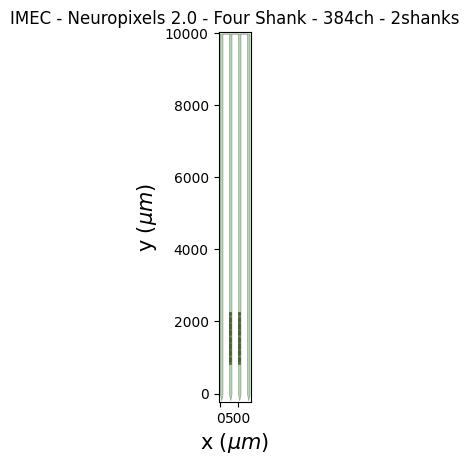

In [6]:
pif.plotting.plot_probe(probe)

In [7]:
raw_rec = si.read_spikeglx(npx2_path, stream_name='imec0.ap')
ttls = si.read_spikeglx(npx2_path, stream_name='nidq')

In [8]:
rec1 = si.highpass_filter(raw_rec, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")

bad_channel_ids ['imec0.ap#AP127' 'imec0.ap#AP328']


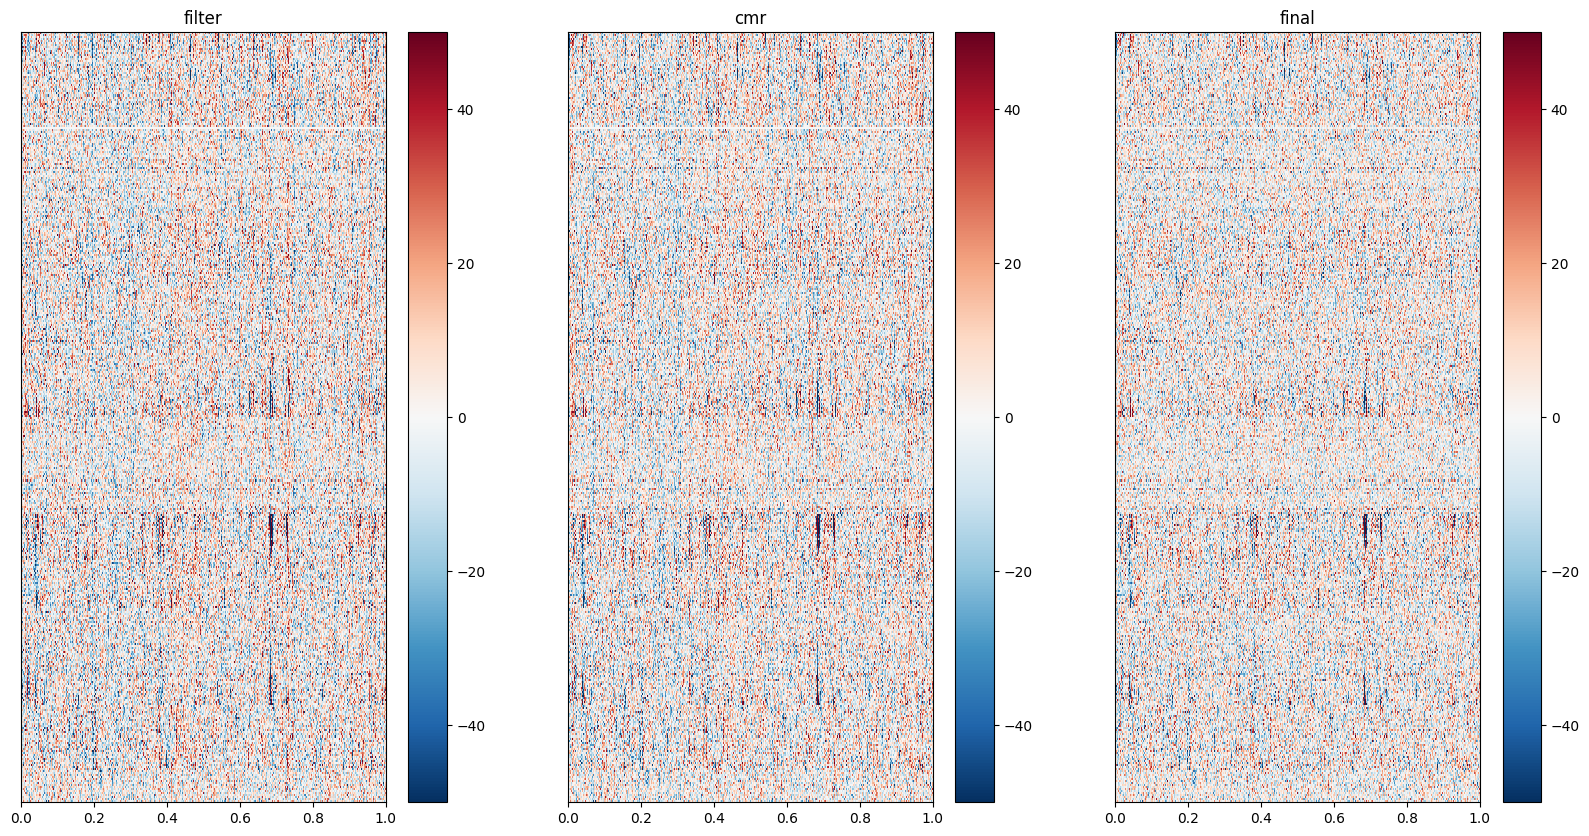

In [9]:
# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

si.plot_timeseries(rec2, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
si.plot_timeseries(rec3, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
si.plot_timeseries(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)
    
plt.show()

In [10]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec4, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec4, return_scaled=False)

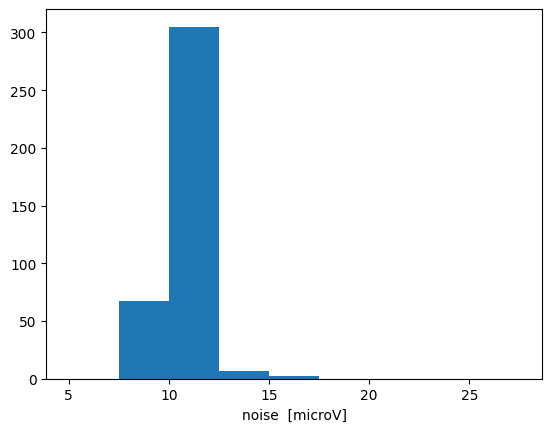

In [11]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [microV]')
plt.show()

In [9]:
ks_working_folder = '/ks2_t'
# Make sure it exits
os.path.exists(ks_working_folder)

False

# **Kilosort requires a binary file as input so the code below does that**

In [23]:
# # Run this only if binary recording hasn't been written yet
# job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
# rec = rec4.save(folder=os.path.join(ks_working_folder,'preprocess'), format='binary', **job_kwargs)

write_binary_recording with n_jobs = 40 and chunk_size = 30000


write_binary_recording:   0%|          | 0/2490 [00:00<?, ?it/s]

## **Run this only if the binary recording has already been written**

In [26]:
rec = si.BinaryRecordingExtractor('/ks2_temp/preprocess/traces_cached_seg0.raw', 30000, 'int16', 382)
# Hacky Steps because Binary recordings does not contain the following properties
rec.set_channel_locations(rec4.get_channel_locations())
rec.set_probe(rec4.get_probe())
rec.set_property('contact_vector', rec4.get_property('contact_vector'))

In [16]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,detect_threshold=5, **job_kwargs)
peaks

detect peaks using locally_exclusive:   0%|          | 0/2490 [00:00<?, ?it/s]

array([(      18, 127, -113., 0), (      80, 193,  -82., 0),
       (     119, 372,  -84., 0), ..., (74699598, 208,  -79., 0),
       (74699643, 195, -127., 0), (74699643, 372,  -80., 0)],
      dtype=[('sample_index', '<i8'), ('channel_index', '<i8'), ('amplitude', '<f8'), ('segment_index', '<i8')])

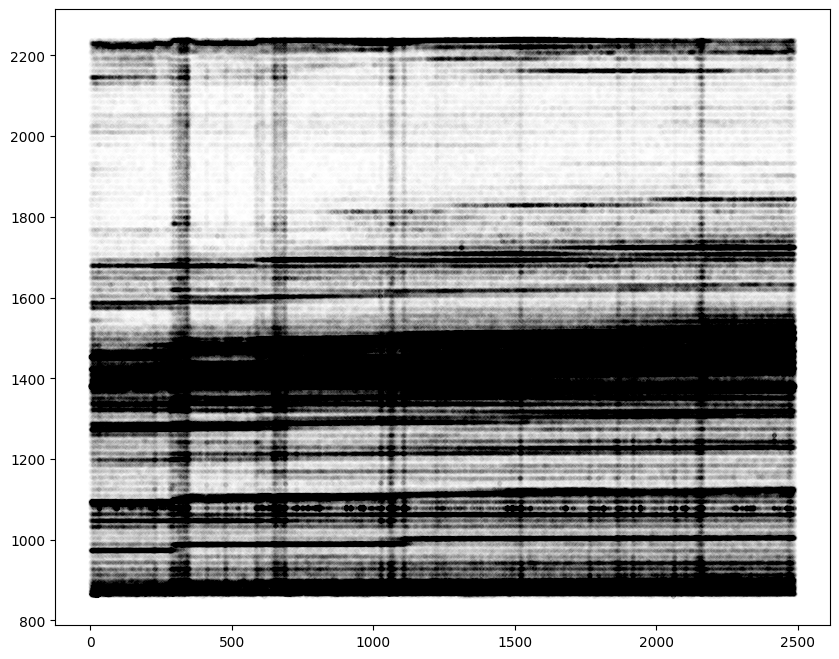

In [26]:
# check for drifts
fs = rec.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

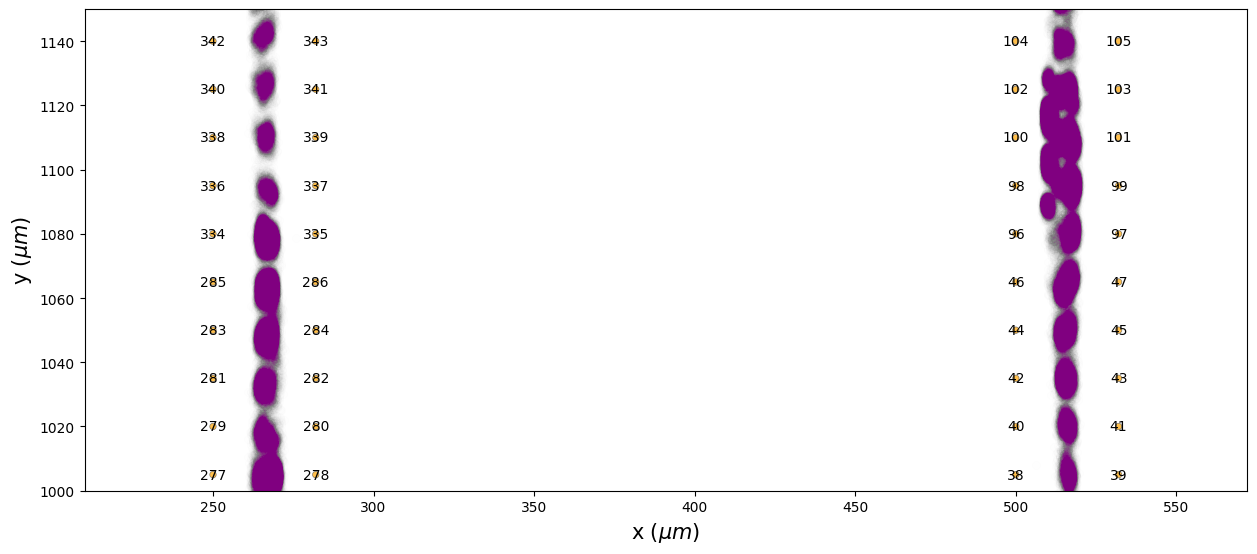

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
ax.set_ylim(1000, 1150)

ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [11]:
ks2_path = '/home/manishm/Kilosort'
si.Kilosort2_5Sorter.set_kilosort2_5_path(ks2_path)
si.Kilosort2_5Sorter.is_installed()

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/manishm/Kilosort


True

In [12]:
ks2_5_params = si.get_default_sorter_params('kilosort2_5')

In [13]:
ks_working_folder = '/ks2_temp'

In [30]:
sorting = si.run_sorter('kilosort2_5', rec, output_folder=os.path.join(ks_working_folder, 'ks2_output'),
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: /ks2_temp/ks2_output/sorter_output/run_kilosort2_5.sh


                            < M A T L A B (R) >

                  Copyright 1984-2021 The MathWorks, Inc.

                  R2021b (9.11.0.1769968) 64-bit (glnxa64)

                             September 17, 2021



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   5s. Loading raw data and applying filters... 

Time 214s. Finished preprocessing 1139 batches. 

Drift correction ENABLED

pitch is 15 um

0.37 sec, 1 batches, 2512 spikes 

25.42 sec, 101 batches, 234929 spikes 

50.47 sec, 201 batches, 505407 spikes 

75.59 sec, 301 batches, 763662 spikes 

100.89 sec, 401 batches, 1043238 spikes 

126.14 sec, 501 batches, 1320133 spikes 

151.37 sec, 601 batches, 1586590 spikes 

176.57 sec, 701 batches, 1860076 spikes 

201.87 sec, 801 batches, 2128505 

### Trying to run Kilosort2 on a slower hard disk to see how long it takes

In [29]:
sorting2 = si.run_sorter('kilosort2_5', rec, output_folder='~/ks2_slow_hd',
                        verbose=True, remove_existing_folder=False, **ks2_5_params)

RUNNING SHELL SCRIPT: /home/manishm/mbl_mouse_2023/student_and_instructor_code/manish/python_stuff/~/ks2_slow_hd/sorter_output/run_kilosort2_5.sh


                            < M A T L A B (R) >

                  Copyright 1984-2021 The MathWorks, Inc.

                  R2021b (9.11.0.1769968) 64-bit (glnxa64)

                             September 17, 2021



 

To get started, type doc.

For product information, visit www.mathworks.com.

 

Time   0s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   6s. Loading raw data and applying filters... 

Time 309s. Finished preprocessing 1139 batches. 

Drift correction ENABLED

pitch is 15 um

0.32 sec, 1 batches, 2512 spikes 

54.01 sec, 101 batches, 234929 spikes 

102.12 sec, 201 batches, 505407 spikes 

150.23 sec, 301 batches, 763662 spikes 

198.36 sec, 401 batches, 1043238 spikes 

246.67 sec, 501 batches, 1320133 spikes 

295.05 sec, 601 batches, 1586590 spikes 

343

In [14]:
# the results can be read back for future session
sorting = si.read_sorter_folder(os.path.join(ks_working_folder, 'ks2_output'))
sorting

KiloSortSortingExtractor: 194 units - 1 segments - 30.0kHz

In [27]:
# we = si.extract_waveforms(rec, sorting, folder=os.path.join(ks_working_folder,'si_waveforms'), **job_kwargs)
# Above line throws a warning that the recording is not filtered, check later if true, for now allow_unfiltered
we = si.extract_waveforms(rec, sorting, folder=os.path.join(ks_working_folder,'si_waveforms'), **job_kwargs, allow_unfiltered=True)

Setting 'return_scaled' to False


extract waveforms memmap:   0%|          | 0/2490 [00:00<?, ?it/s]

In [28]:
si.export_to_phy(we, os.path.join(ks_working_folder, 'si_phy'), **job_kwargs)

/opt/anaconda/envs/spikeinterface/lib/python3.9/site-packages/spikeinterface/exporters/to_phy.py:85: UserWarning: Exporting to Phy with many channels and without sparsity might result in a heavy and less informative visualization. You can use use a sparse WaveformExtractor or you can use the 'sparsity' argument to enforce sparsity (see compute_sparsity())
  warnings.warn(


write_binary_recording:   0%|          | 0/2490 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract amplitudes:   0%|          | 0/2490 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/194 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/194 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/2490 [00:00<?, ?it/s]

Run:
phy template-gui  /ks2_temp/si_phy/params.py


'nidq#AX4' is the odor TTL\
'nidq#AX1' is a quadrature signal\
'nidq#AX2' is a quadrature signal

In [ ]:
this_ids = ['nidq#XA1', 'nidq#XA2', 'nidq#XA4']
this_gain = [ttls.get_channel_property(channel_id=x, key='gain_to_uV') for x in this_ids]
this_offset = [ttls.get_channel_property(channel_id=x, key='offset_to_uV') for x in this_ids]

In [ ]:
# TODO Plot quadrature signals and decoded speed
plt.plot(ttls.get_traces(channel_ids=[this_ids[0]])*this_gain[0] + this_offset[0])
plt.plot(ttls.get_traces(channel_ids=[this_ids[1]])*this_gain[1] + this_offset[1])

# Plotting the Odor indicator to see how to threshold

In [ ]:
this_signal = ttls.get_traces(channel_ids=[this_ids[2]])*this_gain[2] + this_offset[2]
plt.plot(this_signal)
plt.axhline(np.mean(this_signal) + np.std(this_signal), color='black')
plt.axhline(np.mean(this_signal) - np.std(this_signal), color='red')
plt.axhline(np.mean(this_signal) - 2.5*np.std(this_signal), color='green')
plt.axhline(np.mean(this_signal) - 3.5*np.std(this_signal), color='black')

In [ ]:
#The onset times are such that they are less than 2.5 SDs 
#and greater than 3.5 SDs but also the previous time should be  greater than 2.5 SDs
thresh1 = np.mean(this_signal) - 2.5*np.std(this_signal);
thresh2 = np.mean(this_signal) - 3.5*np.std(this_signal);

In [ ]:
temp_idx = np.argwhere((this_signal < thresh1) & (this_signal > thresh2))

In [ ]:
temp_idx = [x[0] for x in temp_idx]

In [ ]:
np.take(this_signal, temp_idx)

In [ ]:
np.shape(onset_idx)

In [ ]:
np.shape(this_signal)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
si.plot_probe_map(raw_rec, ax=ax, with_channel_ids=False)
ax.set_ylim(-100, 4000)

In [ ]:
bad_channel_ids, channel_labels = si.detect_bad_channels(raw_rec)

In [ ]:
channel_labels